## Preparando Entorno
Para iniciar nuestro notebook de Google Colab, es necesario correr los comandos necesarios para instalar pytorch y librerias auxiliares.

In [0]:
!pip install torch torchvision
!pip install matplotlib
# Descarga de dataset de hormigas y abejas...
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2018-08-03 19:39:36--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.230.44.43, 54.230.44.121, 54.230.44.74, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.44.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M   168MB/s    in 0.3s    

2018-08-03 19:39:36 (168 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_dat


  inflating: hymenoptera_data/val/ants/desert_ant.jpg  
  inflating: hymenoptera_data/val/ants/F.pergan.28(f).jpg  
  inflating: hymenoptera_data/val/ants/Hormiga.jpg  
   creating: hymenoptera_data/val/bees/
  inflating: hymenoptera_data/val/bees/1032546534_06907fe3b3.jpg  
  inflating: hymenoptera_data/val/bees/10870992_eebeeb3a12.jpg  
  inflating: hymenoptera_data/val/bees/1181173278_23c36fac71.jpg  
  inflating: hymenoptera_data/val/bees/1297972485_33266a18d9.jpg  
  inflating: hymenoptera_data/val/bees/1328423762_f7a88a8451.jpg  
  inflating: hymenoptera_data/val/bees/1355974687_1341c1face.jpg  
  inflating: hymenoptera_data/val/bees/144098310_a4176fd54d.jpg  
  inflating: hymenoptera_data/val/bees/1486120850_490388f84b.jpg  
  inflating: hymenoptera_data/val/bees/149973093_da3c446268.jpg  
  inflating: hymenoptera_data/val/bees/151594775_ee7dc17b60.jpg  
  inflating: hymenoptera_data/val/bees/151603988_2c6f7d14c7.jpg  
  inflating: hymenoptera_data/val/bees/1519368889_4270261ee

Si se requiere verificar que el notebook cuente con GPU asignada, se puede correr el siguiente comando:

In [0]:
!nvidia-smi

Tue Jul 31 21:09:06 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    70W / 149W |    580MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Transfer Learning
Importar las librerias en python

In [0]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

### PASO 1
Creación de dataset y funciones necesarias.

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### PASO 2
Visualización de unas imágenes.

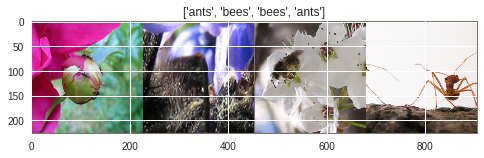

In [38]:
def imshow(inp, title=None):
    """Visualización de imagenes."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# Obtener un conjunto de imagenes
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### PASO 3
Crear la función del modelo

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### PASO 4
Función de realizar inferencia en imagenes

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### PASO 5
Inicializar variables y parametros del modelo

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Optimizador - SGD
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Reducir LR por factor de 0.1 cada 7 iter.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### PASO 6
Entrenar el modelo...

In [42]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7474 Acc: 0.6680
val Loss: 0.9196 Acc: 0.6732

Epoch 1/24
----------
train Loss: 0.6916 Acc: 0.7336
val Loss: 0.4312 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.4970 Acc: 0.8033
val Loss: 0.2923 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.4790 Acc: 0.7910
val Loss: 0.2338 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4895 Acc: 0.7910
val Loss: 0.3350 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4498 Acc: 0.8279
val Loss: 0.8762 Acc: 0.7255

Epoch 6/24
----------
train Loss: 0.5173 Acc: 0.8320
val Loss: 0.5791 Acc: 0.7843

Epoch 7/24
----------
train Loss: 0.4007 Acc: 0.8197
val Loss: 0.3565 Acc: 0.8431

Epoch 8/24
----------
train Loss: 0.2908 Acc: 0.8648
val Loss: 0.2463 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.4147 Acc: 0.8320
val Loss: 0.2376 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3107 Acc: 0.8730
val Loss: 0.2217 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2646 Acc: 0.8689
val Loss: 0.2397 Acc: 0.9020

Ep

### PASO 7
Realizar inferencia con el modelo...

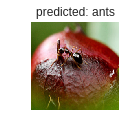

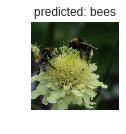

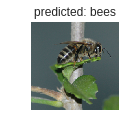

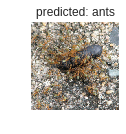

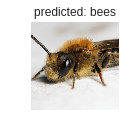

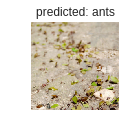

In [43]:
visualize_model(model_ft)

### PASO 8
Guardar modelo para posterior uso.

In [0]:
from google.colab import files

torch.save(model_ft.state_dict(), "model.pth")
files.download('model.pth')  # from colab to browser download